In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
nltk.download('punkt_tab')  # This line is only needed the first time you run the code
nltk.download('stopwords') # This line is only needed the first time you run the code

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lopezgg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lopezgg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data loading

In [2]:
data_dir = "../../data/cancer_type"

In [3]:
df_cancer_type = pd.read_csv(
    os.path.join(data_dir, "tcga-tumor-types.csv"),
    sep=";",
    header=0
)
dict_cancer_type = dict(zip(df_cancer_type["Study Abbreviation"].values, df_cancer_type["Study Name"].values))

## Training

In [4]:
df_train = pd.read_csv(
    os.path.join(data_dir, "train_tcga_reports_cancer_type.csv"),
    sep=',',
    header=0
)

In [5]:
df_train.shape

(4761, 4)

In [6]:
arr_train_corpus = df_train["text"].values.tolist()
arr_train_labels = df_train["cancer_type"].values.tolist()

In [7]:
len(arr_train_corpus), len(arr_train_labels)

(4761, 4761)

In [8]:
len(set(arr_train_labels))

32

## Validation

In [9]:
df_val = pd.read_csv(
    os.path.join(data_dir, "val_tcga_reports_cancer_type.csv"),
    sep=',',
    header=0
)

In [10]:
df_val.shape

(1905, 4)

In [11]:
arr_val_corpus = df_val["text"].values.tolist()
arr_val_labels = df_val["cancer_type"].values.tolist()

In [12]:
len(arr_val_corpus), len(arr_val_labels)

(1905, 1905)

In [13]:
len(set(arr_val_labels))

32

# BoW

In [14]:
arr_stopwords = nltk.corpus.stopwords.words('english')

In [15]:
def tokenizer(text):
    """
    Tokenizes the input text (lowercased) using NLTK's word_tokenize function and removes
    stopwords, punctuation, tokens containing non-alphabetic characters, and tokens with length 1.
    
    Args:
        text (str): The input text to tokenize.
        
    Returns:
        list: A list of tokens.
    """
    arr_tokens = word_tokenize(text.lower())
    # Remove tokens with length 1
    arr_tokens = [token for token in arr_tokens if len(token) > 1]
    # Remove stopwords
    arr_tokens = [token for token in arr_tokens if token not in arr_stopwords]
    # Remove punctuation and tokens containing non-alphabetic characters
    arr_tokens = [token for token in arr_tokens if token.isalpha()]
    return arr_tokens

In [16]:
word_vectorizer = CountVectorizer(
    tokenizer=tokenizer,
    token_pattern=None,
    lowercase=False,
    stop_words=None
)

Fit the BoW model on the training set:

In [17]:
word_vectorizer.fit(arr_train_corpus)

CountVectorizer(lowercase=False, token_pattern=None,
                tokenizer=<function tokenizer at 0x1b3478220>)

In [18]:
# Vocabulary size
len(word_vectorizer.vocabulary_)

23818

In [19]:
dict_index_word = {value: key for key, value in word_vectorizer.vocabulary_.items()}

Transform the training set using the fitted BoW mdoel:

In [20]:
arr_train_bow = word_vectorizer.transform(arr_train_corpus)

In [21]:
arr_train_bow.shape

(4761, 23818)

Transform the validation set using the fitted BoW mdoel:

In [22]:
arr_val_bow = word_vectorizer.transform(arr_val_corpus)

In [23]:
arr_val_bow.shape

(1905, 23818)

# Cancer type classification

## Logistic Regression

In [24]:
clf = LogisticRegression(
    random_state=0,
    max_iter=200
)

### Training

In [25]:
clf.fit(
    X=arr_train_bow,
    y=arr_train_labels,
)

LogisticRegression(max_iter=200, random_state=0)

### Evaluation

#### Train set

In [26]:
arr_train_pred = clf.predict(
    X=arr_train_bow
)

In [27]:
arr_train_pred

array(['KIRC', 'OV', 'OV', ..., 'THCA', 'COAD', 'COAD'],
      shape=(4761,), dtype='<U4')

In [28]:
accuracy_score(
    y_true=arr_train_labels,
    y_pred=arr_train_pred
)

0.9991598403696702

In [29]:
print(classification_report(
    y_true=arr_train_labels,
    y_pred=arr_train_pred
))

              precision    recall  f1-score   support

         ACC       1.00      1.00      1.00        42
        BLCA       1.00      1.00      1.00       180
        BRCA       1.00      1.00      1.00       532
        CESC       1.00      1.00      1.00       155
        CHOL       1.00      1.00      1.00        21
        COAD       1.00      1.00      1.00       213
        DLBC       1.00      1.00      1.00        23
        ESCA       1.00      1.00      1.00        82
         GBM       1.00      1.00      1.00       184
        HNSC       1.00      1.00      1.00       254
        KICH       1.00      1.00      1.00        54
        KIRC       1.00      1.00      1.00       255
        KIRP       1.00      1.00      1.00       143
         LGG       1.00      1.00      1.00       230
        LIHC       1.00      1.00      1.00       183
        LUAD       1.00      0.99      0.99       230
        LUSC       0.99      1.00      0.99       232
        MESO       1.00    

#### Validation set

In [30]:
arr_val_pred = clf.predict(
    X=arr_val_bow
)

In [31]:
accuracy_score(
    y_true=arr_val_labels,
    y_pred=arr_val_pred
)

0.952755905511811

In [32]:
print(classification_report(
    y_true=arr_val_labels,
    y_pred=arr_val_pred
))

              precision    recall  f1-score   support

         ACC       0.93      0.88      0.90        16
        BLCA       0.97      0.99      0.98        70
        BRCA       1.00      1.00      1.00       232
        CESC       0.93      0.91      0.92        45
        CHOL       1.00      0.78      0.88         9
        COAD       0.91      0.96      0.94        85
        DLBC       1.00      0.75      0.86         8
        ESCA       0.97      1.00      0.98        28
         GBM       0.96      0.94      0.95        80
        HNSC       0.98      0.99      0.99       118
        KICH       0.73      0.58      0.65        19
        KIRC       0.92      0.98      0.95       111
        KIRP       0.96      0.89      0.92        55
         LGG       0.92      0.97      0.94       103
        LIHC       0.95      0.98      0.96        56
        LUAD       0.93      0.93      0.93       104
        LUSC       0.90      0.96      0.93        97
        MESO       1.00    

### Performance for each cancer type

In [33]:
arr_val_f1_label = f1_score(
    y_true=arr_val_labels,
    y_pred=arr_val_pred,
    average=None,
    labels=clf.classes_
)

In [34]:
arr_res = []
for i in range(len(clf.classes_)):
    label = clf.classes_[i]
    f1 = arr_val_f1_label[i]
    n_train = len(df_train[df_train["cancer_type"] == label])
    n_val = len(df_val[df_val["cancer_type"] == label])
    arr_res.append({
        "label": label,
        "f1": f1,
        "n_train": n_train,
        "n_val": n_val
    })
df_val_f1_label = pd.DataFrame(arr_res)


In [37]:
df_val_f1_label.sort_values(
    by="f1",
    ascending=True
)

,label,f1,n_train,n_val
30,UCS,0.625000,29,8
10,KICH,0.647059,54,19
22,READ,0.842105,84,31
6,DLBC,0.857143,23,8
4,CHOL,0.875000,21,9
23,SARC,0.886076,125,43
0,ACC,0.903226,42,16
20,PCPG,0.916667,91,35
3,CESC,0.921348,155,45
12,KIRP,0.924528,143,55


In [36]:
# Create the scatter plot
fig = px.scatter(
    df_val_f1_label, 
    x='n_train', 
    y='f1', 
    text='label',
    title='F1 Score vs Number of Training Samples per Cancer Type',
    labels={'f1': 'F1 Score', 'n_train': 'Number of Training Samples', 'n_val': 'Number of Validation Samples'},
    hover_data=['label', 'f1', 'n_train', 'n_val']
)

fig.update_traces(textposition='top center')
fig.update_layout(height=600, width=800)

fig.show()

In [45]:
df_val_f1_label_filter = df_val_f1_label[
    ~df_val_f1_label["label"].isin([
        "UVM",
        "TGCT",
        "MESO",
        "SKCM",
        "THYM",
        "PAAD",
        "ESCA"
    ])
].copy()

In [46]:
# Create the scatter plot
fig = px.scatter(
    df_val_f1_label_filter, 
    x='n_train', 
    y='f1', 
    text='label',
    title='F1 Score vs Number of Training Samples per Cancer Type',
    labels={'f1': 'F1 Score', 'n_train': 'Number of Training Samples', 'n_val': 'Number of Validation Samples'},
    hover_data=['label', 'f1', 'n_train', 'n_val']
)

fig.update_traces(textposition='top center')
fig.update_layout(height=600, width=800)

fig.show()

In [48]:
from scipy.optimize import curve_fit

# Define a function to fit (logarithmic model)
def log_func(x, a, b):
    return a * np.log(x) + b

# Fit the curve
x_data = df_val_f1_label_filter['n_train']
y_data = df_val_f1_label_filter['f1']
params, _ = curve_fit(log_func, x_data, y_data)

# Predict values using the fitted model
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = log_func(x_fit, *params)

# Plot
fig = px.scatter(
    df_val_f1_label_filter,
    x='n_train',
    y='f1',
    text='label',
    labels={'n_train': 'Number of Training Samples', 'f1': 'F1 Score'},
    hover_data=['label', 'n_train', 'n_val', 'f1'],
    title='F1 Score vs Number of Training Samples per Cancer Type'
)

# Add fitted curve
fig.add_scatter(x=x_fit, y=y_fit, mode='lines', name='Log Fit', line=dict(color='red', dash='dash'))

fig.update_traces(textposition='top center')
fig.update_layout(height=600, width=800)

fig.show()

### Feature importance

In [39]:
clf.coef_.shape

(32, 23818)

In [33]:
clf.classes_

array(['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA',
       'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LGG', 'LIHC', 'LUAD',
       'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC',
       'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM'],
      dtype='<U4')

In [34]:
# Function to plot top 10 words for each class
def plot_top_words(coefficients, classes, dict_index_word, dict_cancer_type, top_n=10):
    for i, class_label in enumerate(classes):
        # Get the top N indices for the current class
        top_indices = np.argsort(coefficients[i])[-top_n:]
        top_words = [dict_index_word[idx] for idx in top_indices]
        top_values = coefficients[i][top_indices]

        # Plot the top words
        plt.figure(figsize=(10, 5))
        plt.barh(top_words, top_values, color='skyblue')
        plt.xlabel("Coefficient Value")
        plt.ylabel("Words")
        plt.title(f"Top {top_n} Words for Class: {class_label} ({dict_cancer_type[class_label]})")
        plt.show()

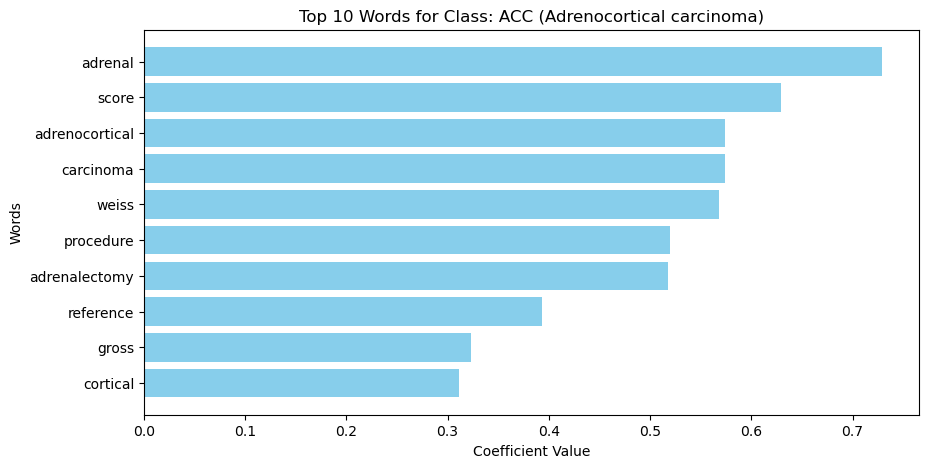

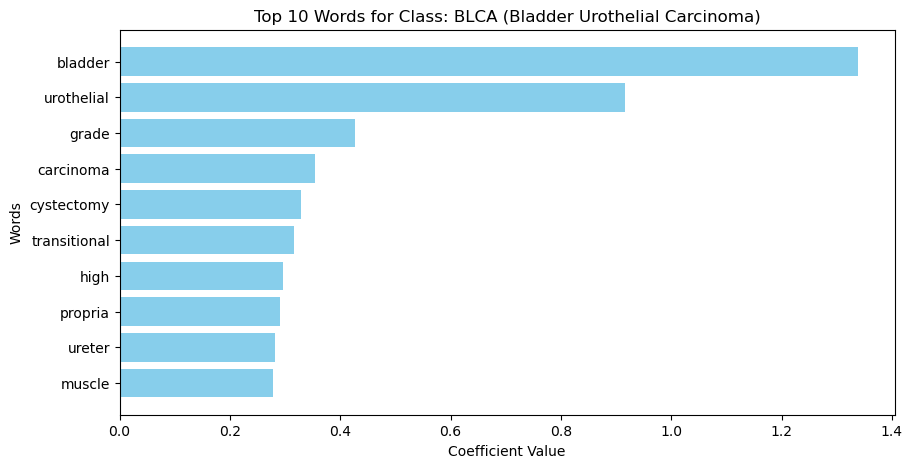

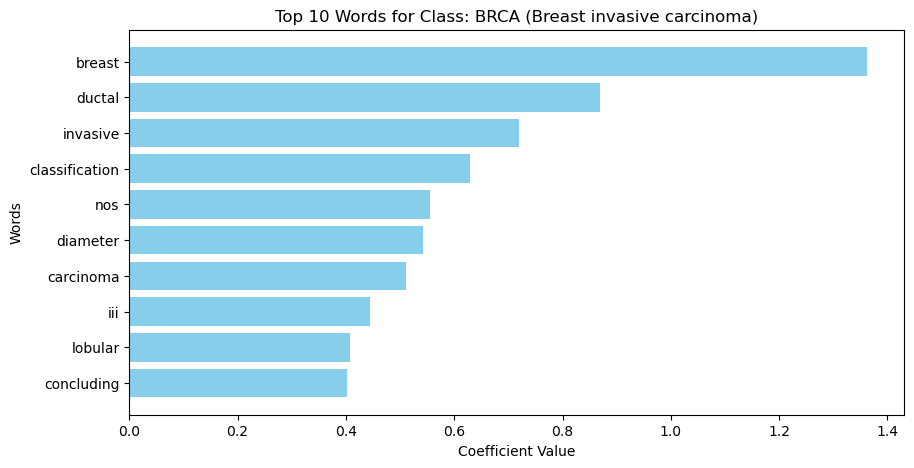

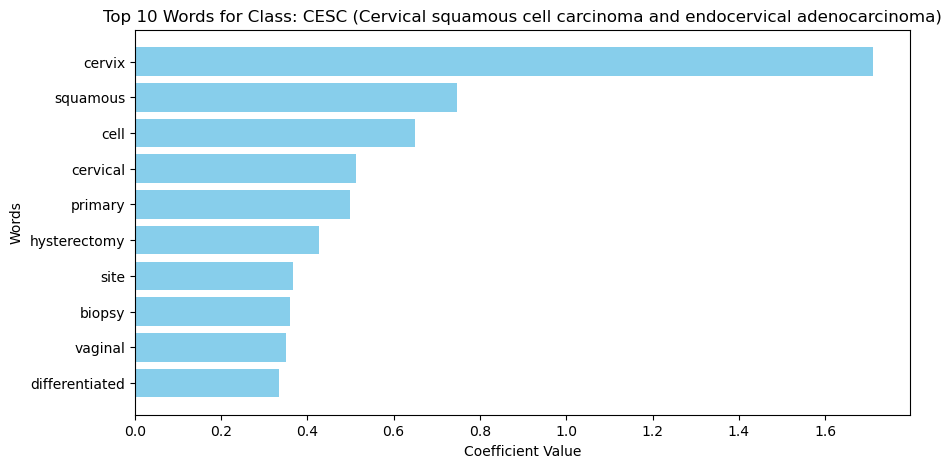

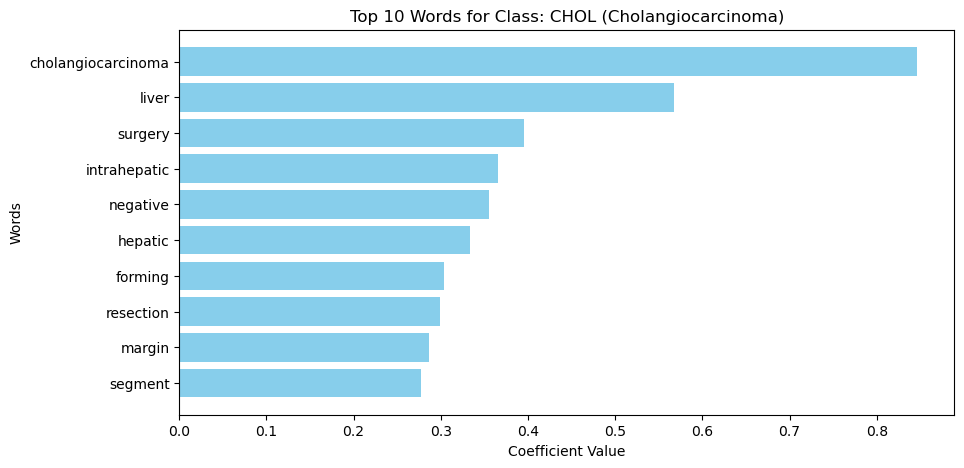

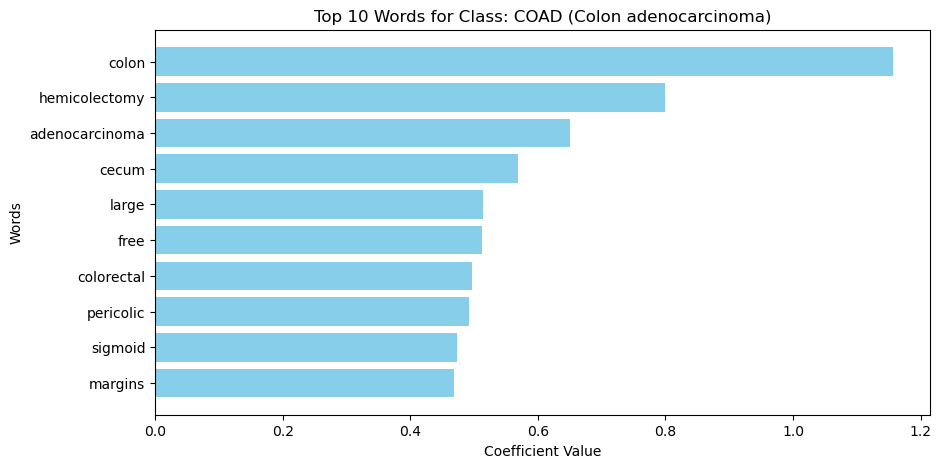

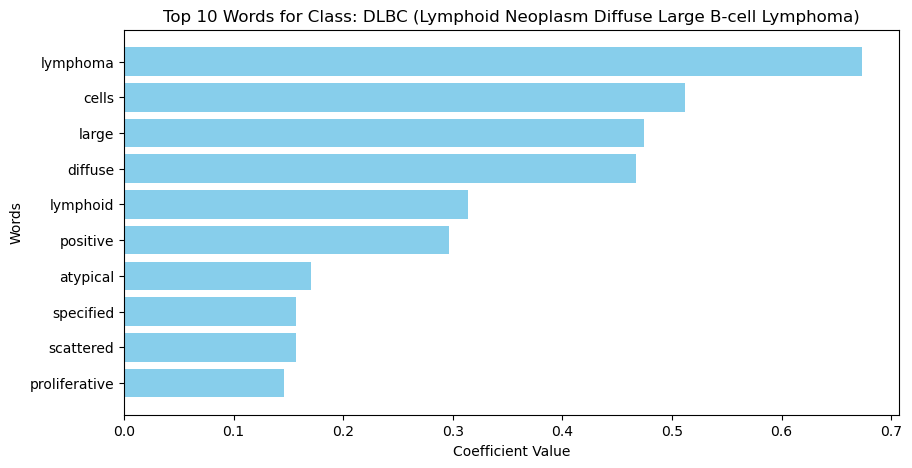

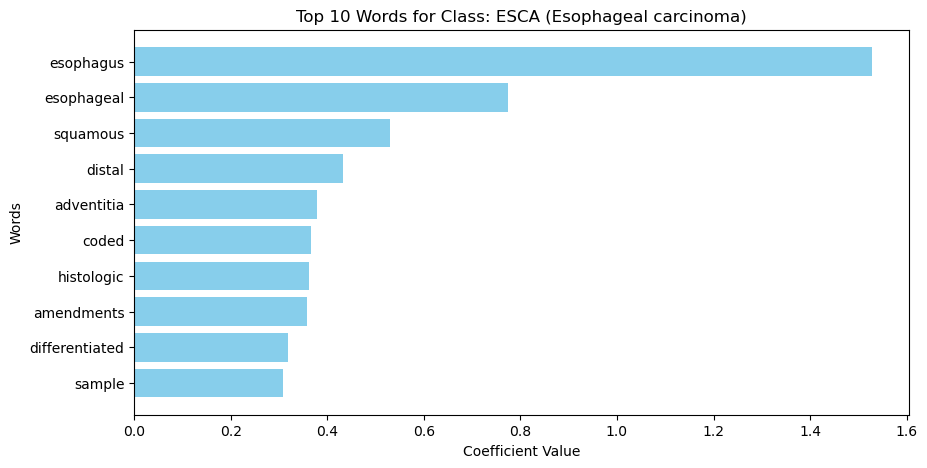

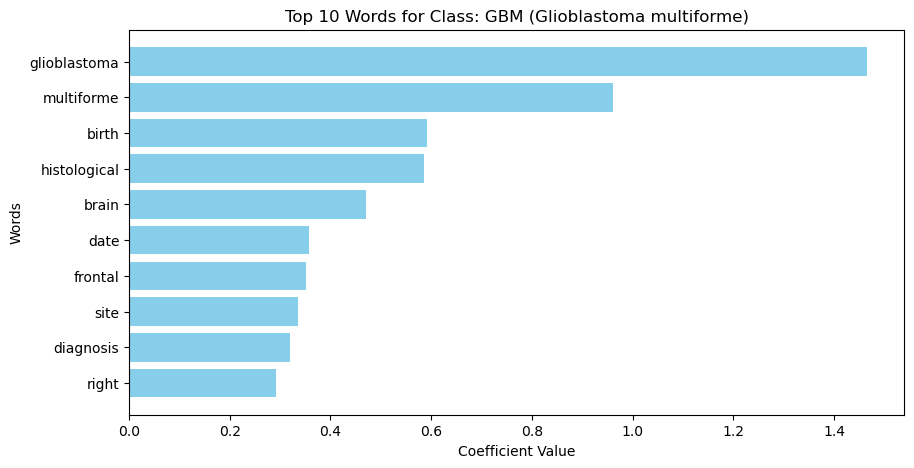

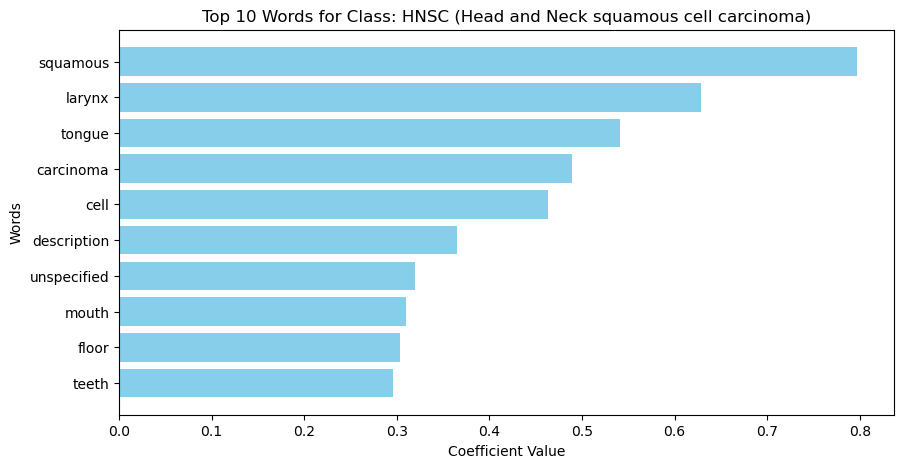

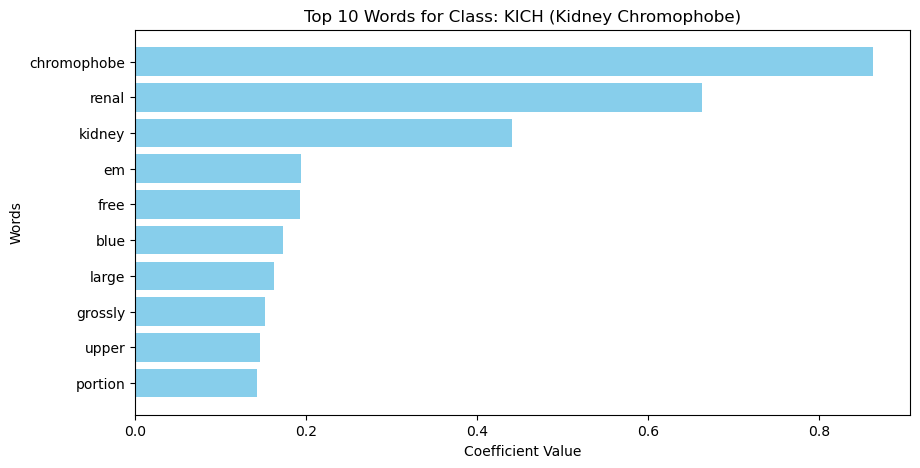

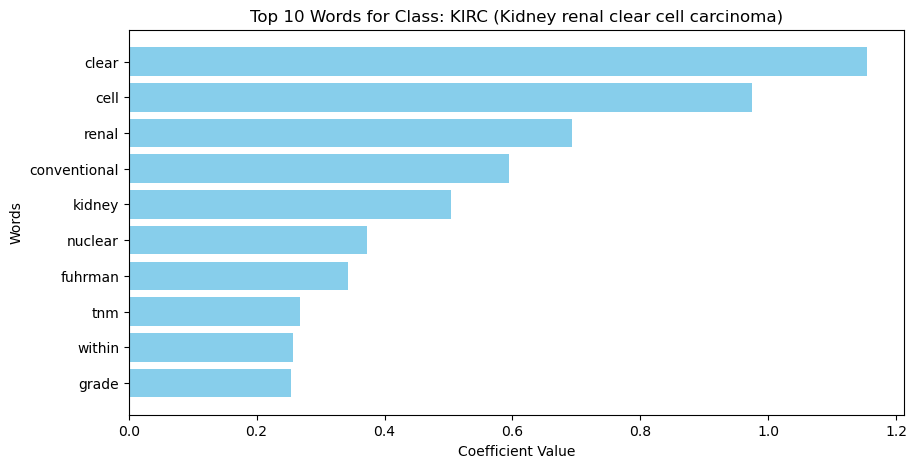

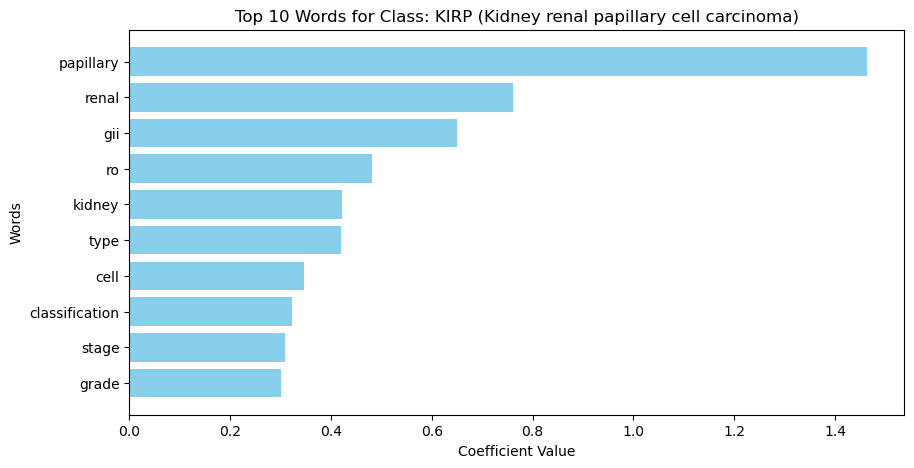

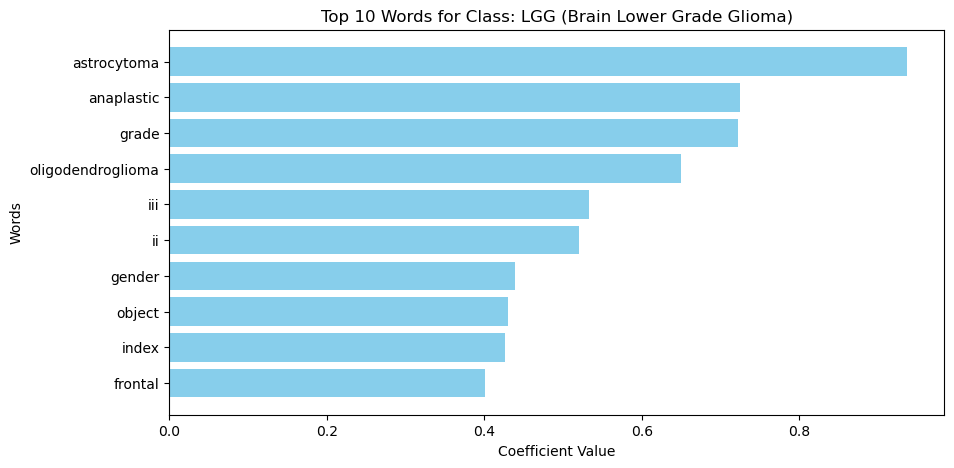

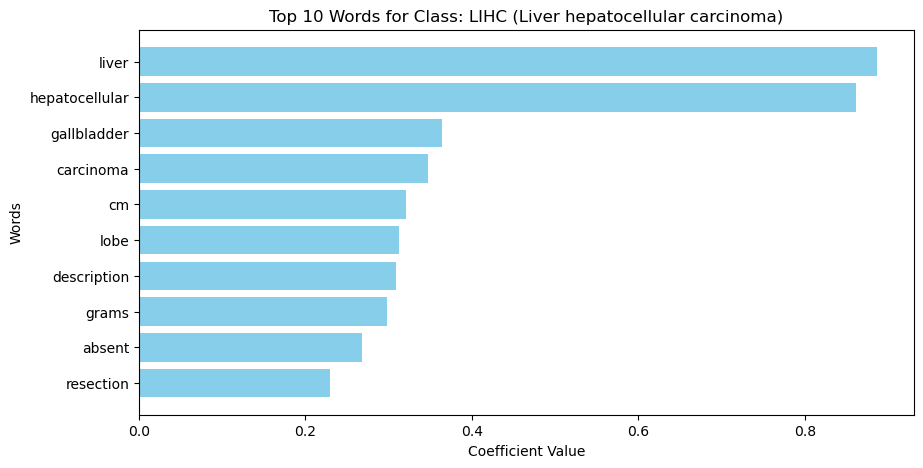

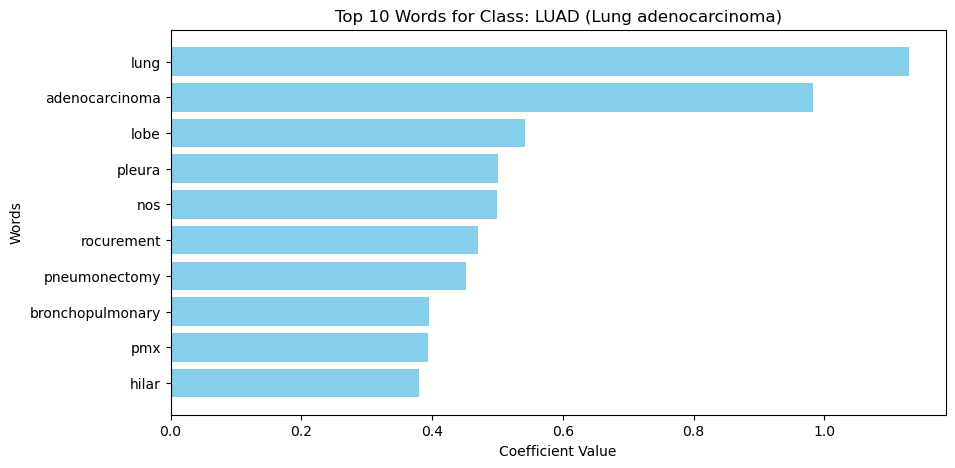

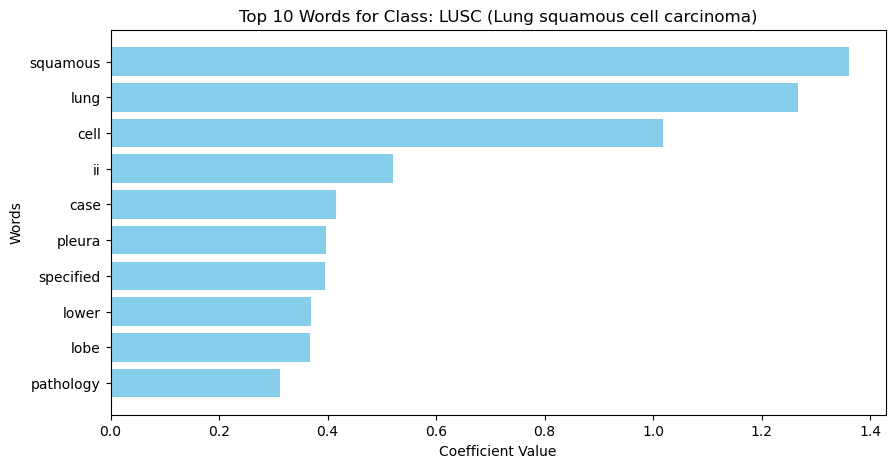

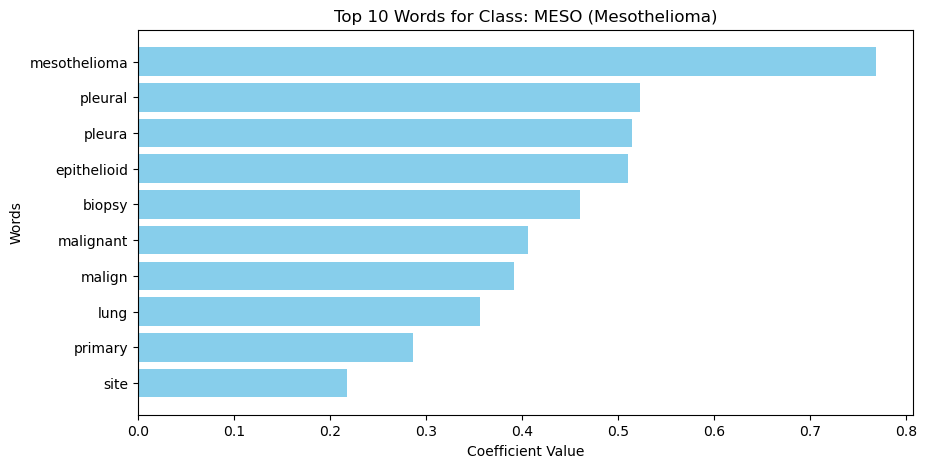

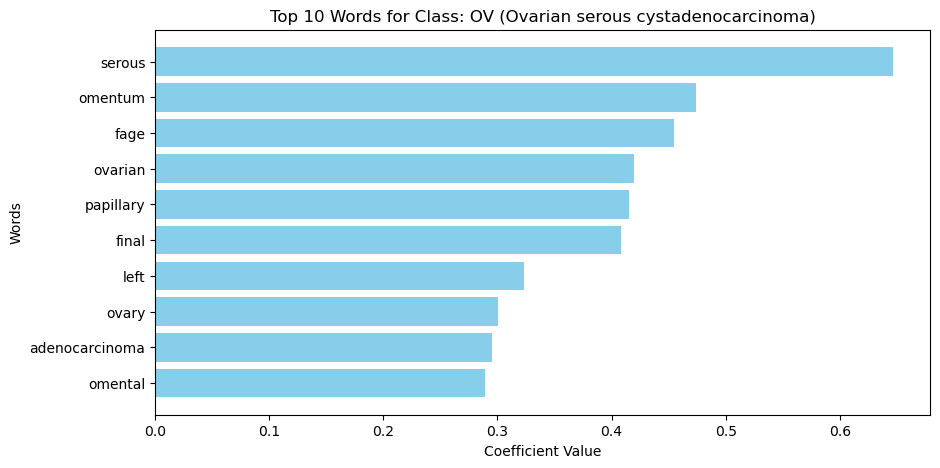

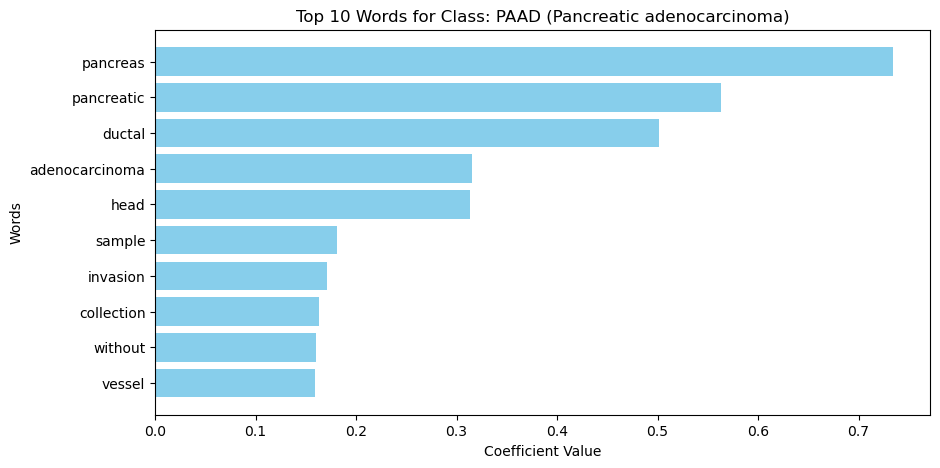

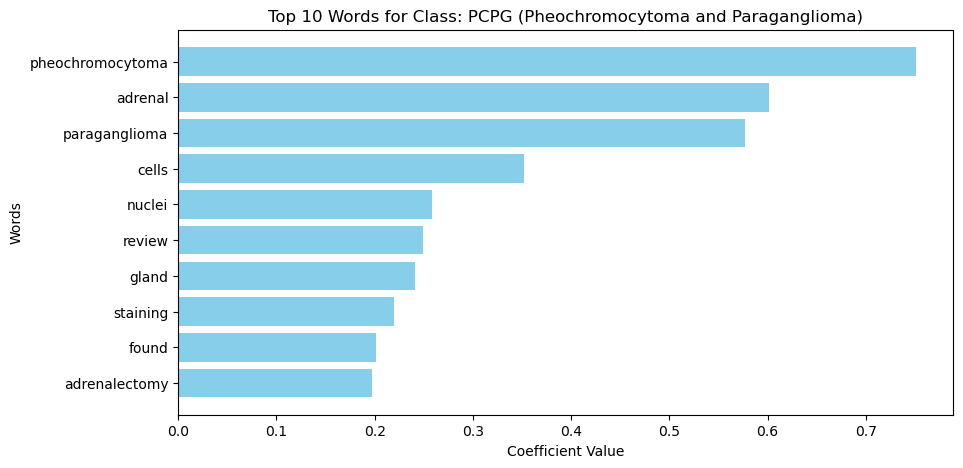

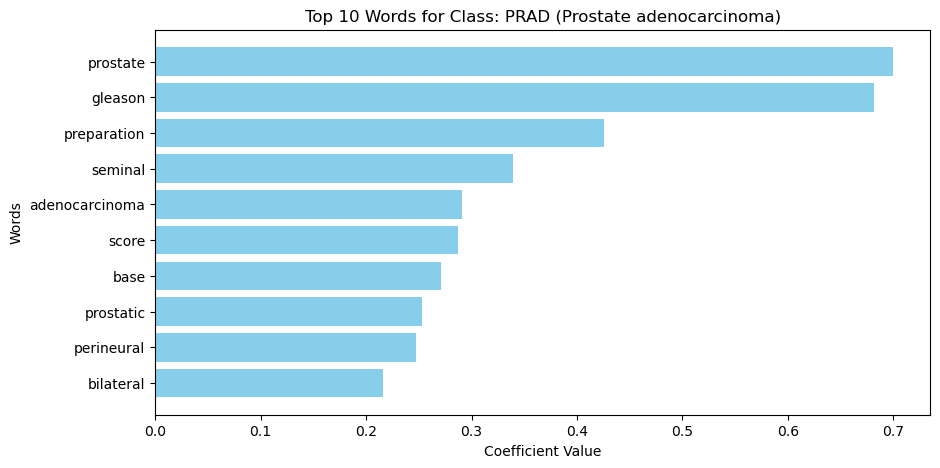

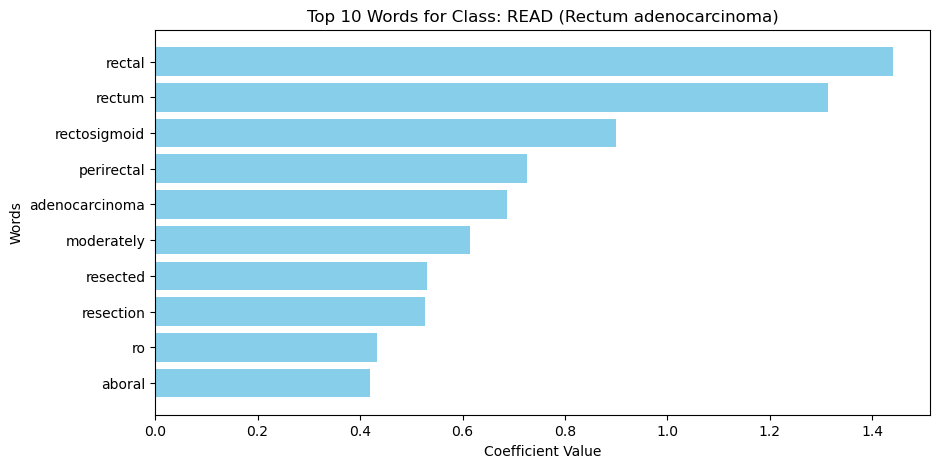

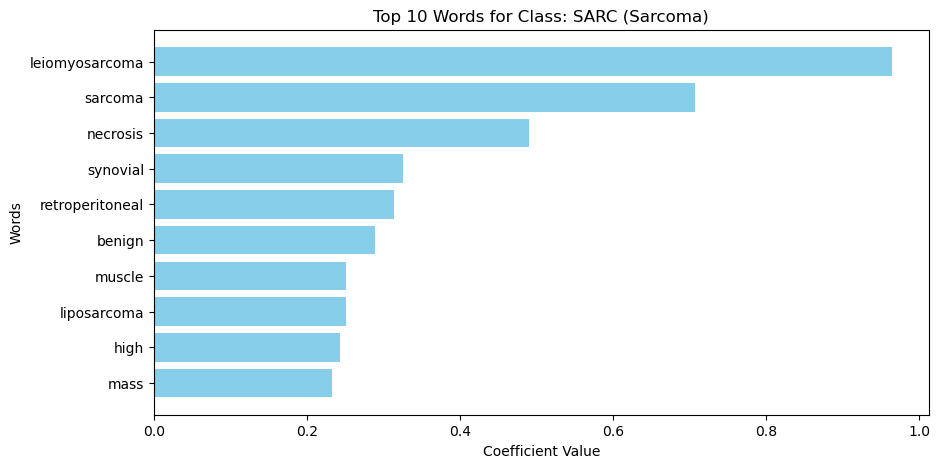

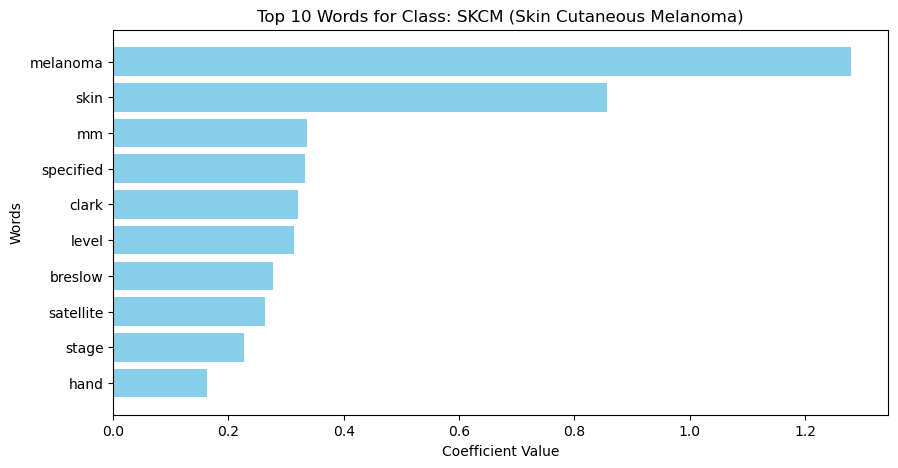

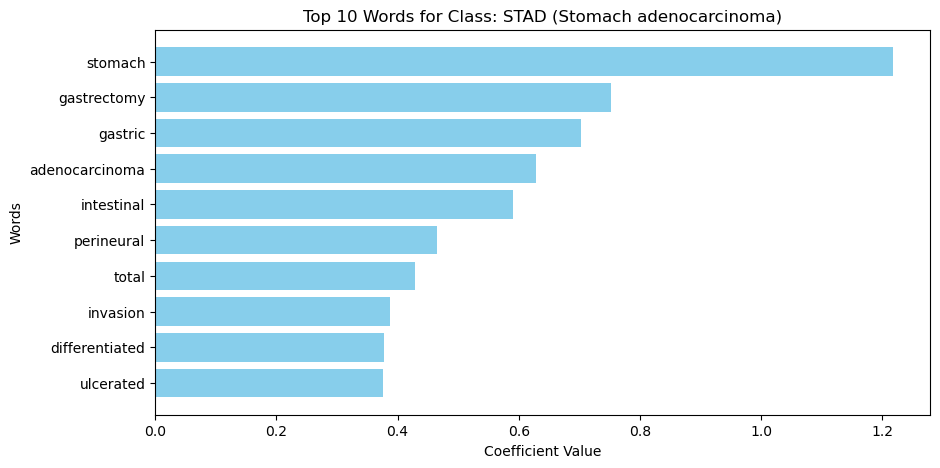

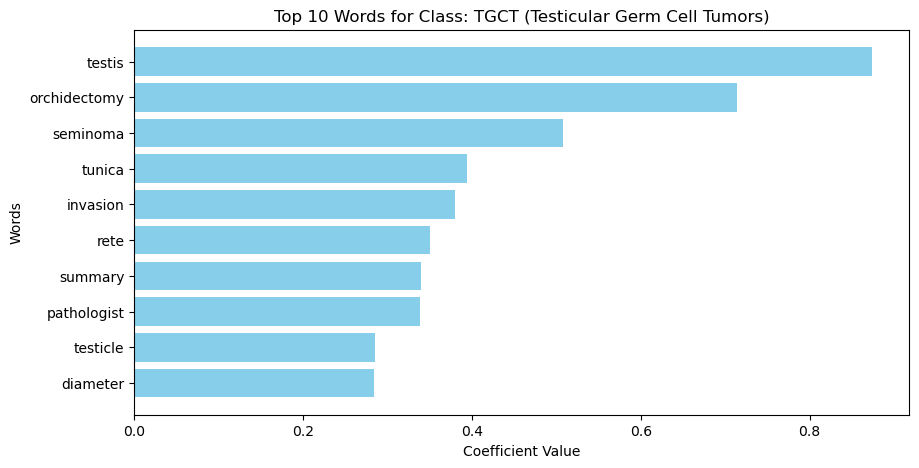

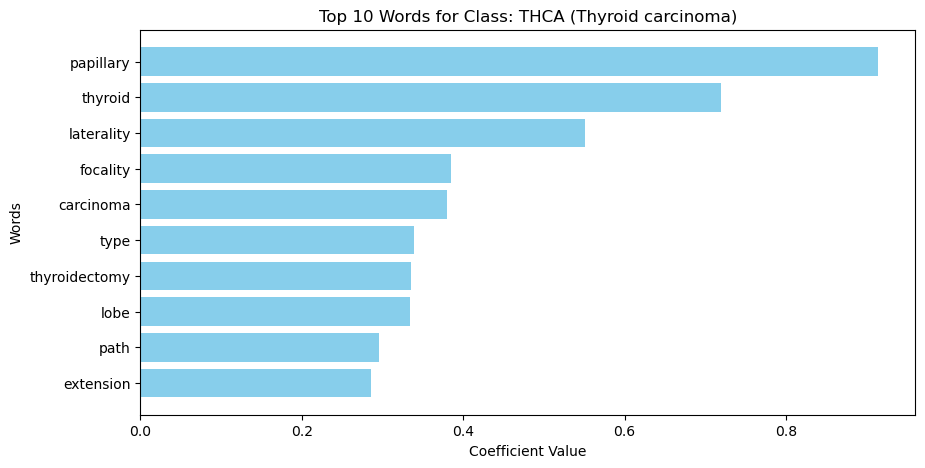

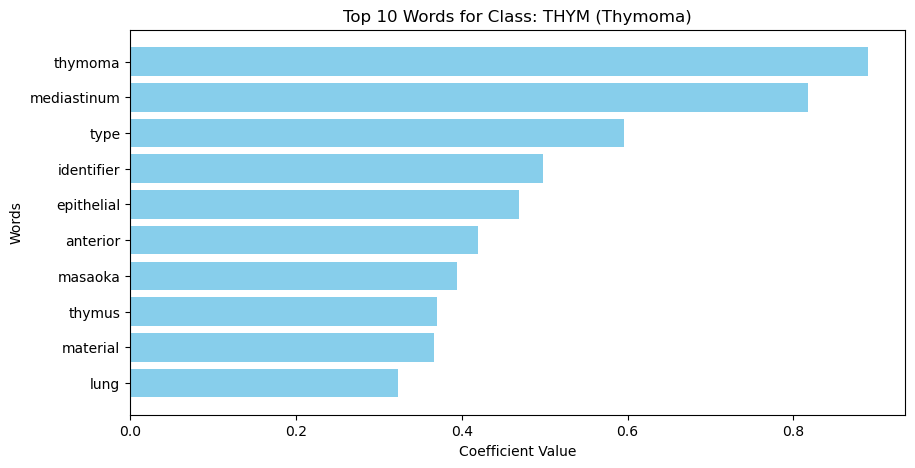

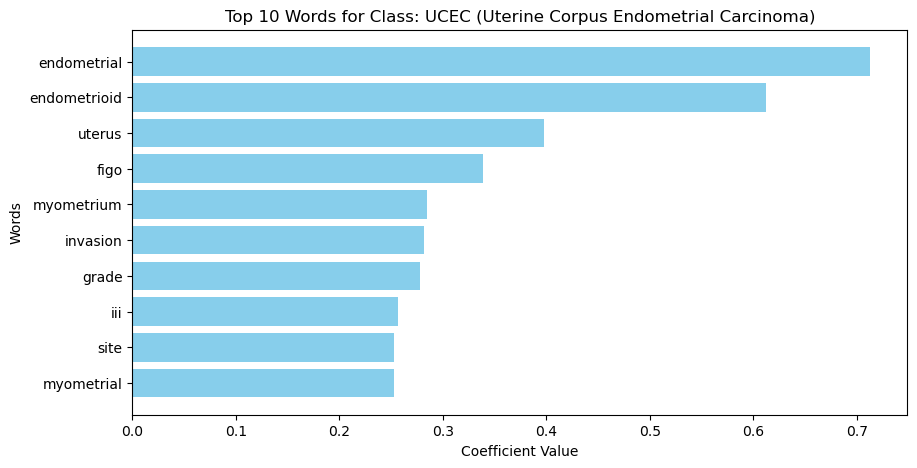

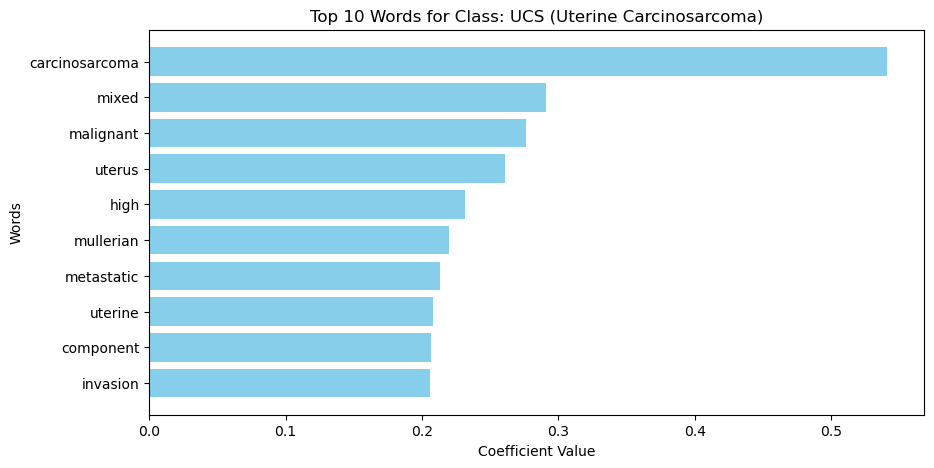

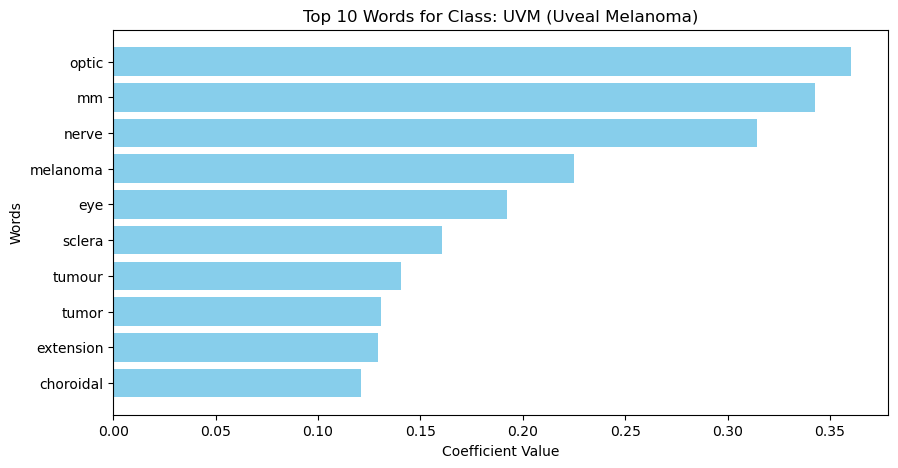

In [35]:
plot_top_words(
    coefficients=clf.coef_,
    classes=clf.classes_,
    dict_index_word=dict_index_word,
    dict_cancer_type=dict_cancer_type,
    top_n=10
)